Sources:
- https://segmentation-models.readthedocs.io/en/latest/index.html
- https://github.com/bnsreenu/python_for_microscopists (177)

In [ ]:
!pip install tensorflow==2.8.0
!pip install keras-applications==1.0.7

from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import glob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 84.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 59.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.0
    Uninstalling tensorboard-data-server-0.7.0:
      Successfully uninstalled tensorboard-data-server-0.7.0
  Attempting uninstall: google-auth-oauthlib
    Fo

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
image_directory = '/content/drive/MyDrive/Colab Notebooks/koro/images_256/'
mask_directory = '/content/drive/MyDrive/Colab Notebooks/koro/masks_256/'

In [ ]:
SIZE = 256
num_images = 2000

Images aren't loaded in any chronological order

In [ ]:
image_names = glob.glob(image_directory + "*.tif")
# print(image_names)

In [ ]:
image_names.sort()
# print(image_names)

In [ ]:
image_names_subset = image_names[0:num_images]
images = [cv2.imread(img, 0) for img in image_names_subset]


image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

In [ ]:
mask_names = glob.glob(mask_directory + "*.png")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]

mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [ ]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (2000, 256, 256, 1)
Mask data shape is:  (2000, 256, 256, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


In [ ]:
#Normalize images
image_dataset = image_dataset /255.  
mask_dataset = mask_dataset /255.  #PIxel values will be 0 or 1

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)
# print(type(X_train))

Store the test data on the hard drive to ensure its availability for conducting accurate evaluations in the future.

In [ ]:
import os

save_dir_images = "/content/drive/MyDrive/Colab Notebooks/koro/images_256_test"
for i, img_array in enumerate(X_test):
  img_array = np.squeeze(img_array, axis=-1)
  img_array = (img_array * 255).astype(np.uint8)
  image = Image.fromarray(img_array)
  image.save(os.path.join(save_dir_images, f'image_{i}.png'))

save_dir_masks = "/content/drive/MyDrive/Colab Notebooks/koro/masks_256_test"
for i, mask_array in enumerate(y_test):
  mask_array = np.squeeze(mask_array, axis=-1)
  mask_array = (mask_array * 255).astype(np.uint8)
  mask = Image.fromarray(mask_array)
  mask.save(os.path.join(save_dir_masks, f'mask_{i}.png'))

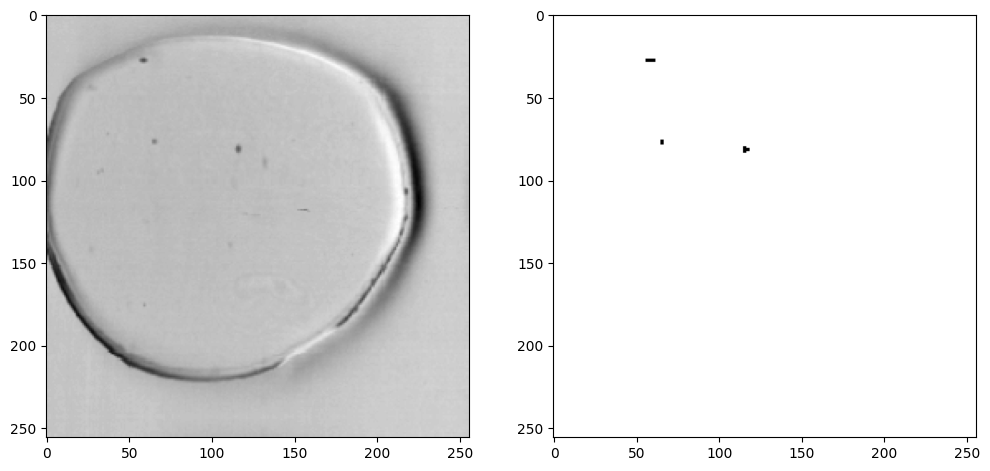

In [ ]:
 #Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [ ]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [ ]:
!pip install segmentation-models

import segmentation_models as sm
sm.set_framework('tf.keras')

BACKBONE = "resnet34"

# define model
model = sm.Unet(BACKBONE, input_shape=input_shape, encoder_weights=None) 
model.compile('Adam', loss='binary_crossentropy', metrics=['accuracy'],)

#print(model.summary())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Alternative:
- Add extra convolution layer to map N -> 3 channels data and train with pretrained weights. 'imagenet'
- https://segmentation-models.readthedocs.io/en/latest/tutorial.html#models-and-backbones

In [ ]:
# !pip install segmentation-models

import segmentation_models as sm
from keras.layers import Input, Conv2D
from keras.models import Model
sm.set_framework('tf.keras')

N = X_train.shape[-1]

base_model = sm.Unet(backbone_name='resnet34', encoder_weights='imagenet')

inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = base_model(l1)

model = Model(inp, out, name=base_model.name)
model.compile('Adam', loss='binary_crossentropy', metrics=['accuracy'],)

85532672/85521592 [==============================] - 2s 0us/step


In [ ]:
history = model.fit(X_train, y_train, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/50
200/200 [==============================] - 42s 175ms/step - loss: 0.1114 - accuracy: 0.9779 - val_loss: 0.0486 - val_accuracy: 0.9922
Epoch 2/50
200/200 [==============================] - 32s 160ms/step - loss: 0.0111 - accuracy: 0.9978 - val_loss: 0.0337 - val_accuracy: 0.9930
Epoch 3/50
200/200 [==============================] - 32s 162ms/step - loss: 0.0067 - accuracy: 0.9983 - val_loss: 0.0065 - val_accuracy: 0.9982
Epoch 4/50
200/200 [==============================] - 32s 161ms/step - loss: 0.0054 - accuracy: 0.9984 - val_loss: 0.0049 - val_accuracy: 0.9984
Epoch 5/50
200/200 [==============================] - 32s 160ms/step - loss: 0.0050 - accuracy: 0.9984 - val_loss: 0.0051 - val_accuracy: 0.9982
Epoch 6/50
200/200 [==============================] - 32s 160ms/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 0.0042 - val_accuracy: 0.9985
Epoch 7/50
200/200 [==============================] - 31s 157ms/step - loss: 0.0048 - accuracy: 0.9984 - val_loss: 0.0048 - val_ac

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

from tensorflow.keras.metrics import MeanIoU

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy()) # above .9 would be a dream

Mean IoU = 0.921319


(1, 256, 256, 1)
(256, 256)


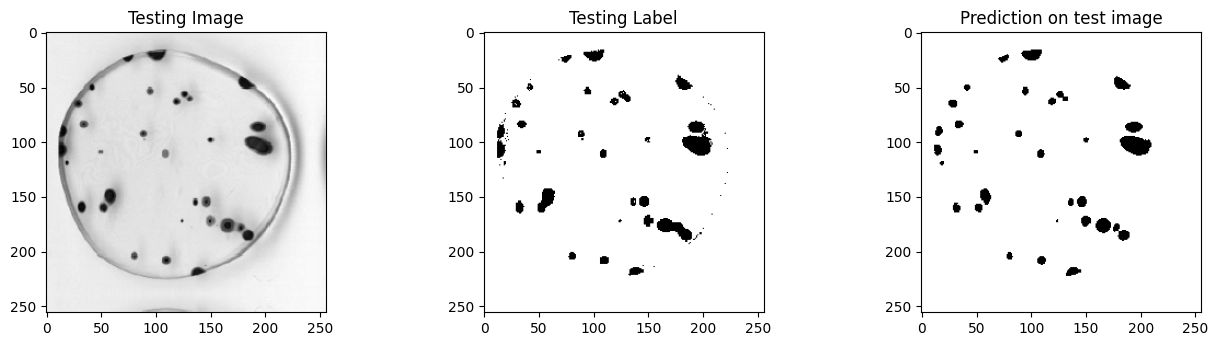

In [ ]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth= y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(cv2.cvtColor((ground_truth * 255).astype(np.uint8), cv2.COLOR_BGR2RGB), cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [ ]:
#Save the model for future use
model.save('/content/drive/MyDrive/Colab Notebooks/korropad/korropad_sm_noEncoder_256_b8_e50_2000.hdf5')

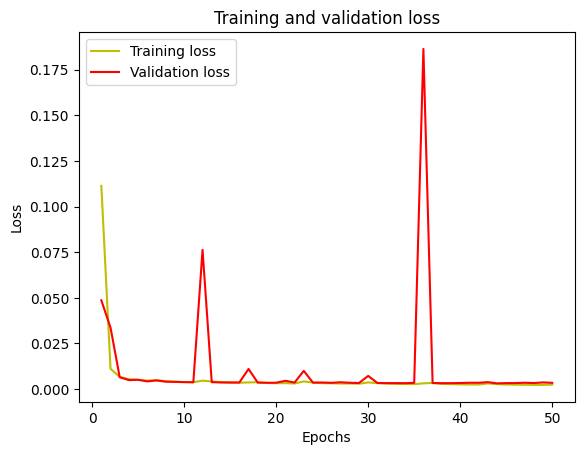

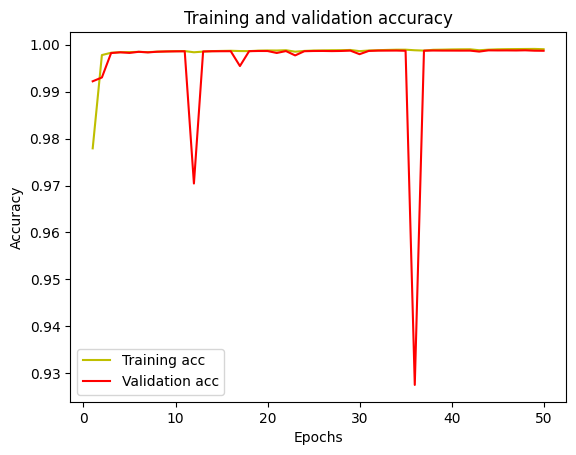

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()